# CTR bootstrap

Цель: оценить CTR (click-through rate) и получить доверительный интервал для данной оценки.

## EDA

In [1]:
import pandas as pd
import datetime as dt

Источник данных: [Kaggle](https://www.kaggle.com/code/kerneler/starter-context-ad-clicks-dataset-7dfe4924-2/data)

##### Данные по кликам на рекламу на сайтах партнеров рекламного агентства

In [2]:
impressions = pd.read_csv('./train.csv')
impressions['impression_time'] = pd.to_datetime(impressions['impression_time'])
impressions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   impression_id    237609 non-null  object        
 1   impression_time  237609 non-null  datetime64[ns]
 2   user_id          237609 non-null  int64         
 3   app_code         237609 non-null  int64         
 4   os_version       237609 non-null  object        
 5   is_4G            237609 non-null  int64         
 6   is_click         237609 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 12.7+ MB


In [3]:
impressions.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [4]:
impressions.nunique()

impression_id      237609
impression_time     36461
user_id             74723
app_code              490
os_version              3
is_4G                   2
is_click                2
dtype: int64

impression_id - id показа рекламы  
impression_time - время показа рекламы  
user_id - id пользователя  
is_click - нажатие на рекламу

In [5]:
print(f'Временной период: {impressions.impression_time.min()} - {impressions.impression_time.max()}')

Временной период: 2018-11-15 00:00:00 - 2018-12-13 07:43:00


## Предварительная оценка CTR

Было выяснено, что для получения состоятельно результата, необходимо собрать данные, которые мы можем получить примерно за месяц. Предположим, реклама висит уже неделю. За это время были собраны данные по кликам, но для проведения теста их пока не достаточно. Однако требуется провести тест уже сейчас

In [6]:
start_date = dt.datetime(2018, 11, 15)
end_date = dt.datetime(2018, 11, 21)
dt_mask = (impressions['impression_time'] > start_date) & (impressions['impression_time'] < end_date)  # недельные данные

In [7]:
click_data = impressions[['impression_id', 'impression_time', 'user_id', 'is_click']]
click_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   impression_id    237609 non-null  object        
 1   impression_time  237609 non-null  datetime64[ns]
 2   user_id          237609 non-null  int64         
 3   is_click         237609 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.3+ MB


In [8]:
click_data[['impression_id', 'user_id']].nunique()

impression_id    237609
user_id           74723
dtype: int64

In [9]:
ctr_mean = click_data['is_click'].mean()

In [10]:
print('CTR: {:.2%}'.format(ctr_mean))

CTR: 4.57%


## Сравнение быстродействия классического и Пуассоновоского бутстрапа

In [11]:
import numpy as np
import timeit

In [12]:
def poisson_bootstrap(B):
    # работает при n >= 100, так как сумма элементов вектора не фиксирована и не равна n (доп. источник вариации)
    sampled = np.random.poisson(1, B)

def multinomial_bootstrap(n):
    # сумма элементов вектора фиксирована и равна n
    sampled = np.random.multinomial(n, [1. / n] * n)

In [13]:
n = len(click_data)
B = 1000
print(n, B)

237609 1000


In [14]:
# средняя сумма k в одной подвыборке для классического бутстрапа совпадает с n
multinomial_samples = np.array([np.random.multinomial(n, [1. / n] * n) for i in range(B)])
np.mean([np.sum(multinomial_samples[i]) for i in range(B)])

237609.0

In [15]:
# средняя сумма k в одной подвыборке для Пуассоновского бутстрапа аппроксимирует n
poisson_samples = np.array([np.random.poisson(1, B) for i in range(n)]).T
np.mean([np.sum(poisson_samples[i]) for i in range(B)])

237634.774

При больших n этим можно пренебречь.

In [16]:
%%timeit
# генерируем вектор длины B из пуассоновского распределения n раз (независимо один раз для каждого наблюдения)
list(map(poisson_bootstrap, [B for i in range(n)]))

18.7 s ± 655 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
# генерируем вектор длины n из мультиномиального распределения B раз
list(map(multinomial_bootstrap, [n for i in range(B)]))

44.6 s ± 920 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


\* Ускоренный станадартный бутстрап

In [18]:
from numba import njit

In [19]:
fast_multinomial_bootstrap = njit(multinomial_bootstrap)

In [20]:
%%timeit
list(map(fast_multinomial_bootstrap, [n for i in range(B)]))

34.2 s ± 944 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Вывод: Пуассоновский бутстрап работает быстрее. Классический бутстрап запускать довольно дорого по времени и по памяти, а если используются параллельные вычисления, то необходимо также контролировать сумму весов наблюдений (= n), генерируемых из биномиального распределения, для каждой бутстраповской выборки. Пуассоновская аппроксимация дает свободу от: 1) знания n, которое требуется для генерации весов из биномиального распределения; 2) проблем, которые создаются параллельными вычислениями, для классического бутстрапа.

## Сравнение на примере оценки доверительного интервала для CTR

In [21]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
alpha = 0.05

##### Классический бутстрап

Необходимо знать n, то есть иметь конечную выборку

In [40]:
def multinomial_boot(main_sample, B):
    result = []
    for rep in range(B):
        sample = resample(main_sample)
        result.append(np.mean(sample))
    result = pd.Series(result)
    return result

In [41]:
%%timeit
multinomial_boot(click_data['is_click'].values.tolist(), B)

1min 44s ± 2.92 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
classic_boot_res = multinomial_boot(click_data['is_click'].values.tolist(), B)

In [43]:
print('Исходно: {:.7f}'.format(ctr_mean))
print('Бутстрап: {:.7f}'.format(classic_boot_res.mean()))
quantile_l = np.quantile(classic_boot_res, alpha / 2)
quantile_r = np.quantile(classic_boot_res, 1 - alpha / 2)
print('Доверительный инетрвал: ({:.7f}; {:.7f})'.format(quantile_l, quantile_r))
print('Стандартная ошибка: {:.7f}'.format(classic_boot_res.std()))
bias = classic_boot_res.mean() - ctr_mean
print(f'Смещение: {bias}')

Исходно: 0.0457138
Бутстрап: 0.0457282
Доверительный инетрвал: (0.0449435; 0.0465976)
Стандартная ошибка: 0.0004258
Смещение: 1.442706294794982e-05


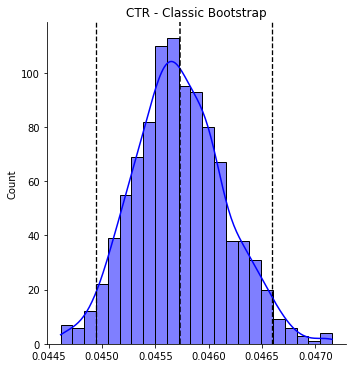

In [44]:
sns.displot(classic_boot_res, kde=True, color='blue')
plt.title('CTR - Classic Bootstrap')
plt.axvline(classic_boot_res.mean(), ls='--', lw=1.5, c='black')
plt.axvline(quantile_l, ls='--', lw=1.3, c='black')
plt.axvline(quantile_r, ls='--', lw=1.3, c='black')
plt.show()

##### Пуассоновский бутстрап

Не зависит от n, данные можно обрабатывать потоково и остановить процедуру в любой момент

In [31]:
def poisson_boot(data_source, B):
    result = np.array([[0, 0]] * B)  # значения будут обновляться при поступлении нового наблюдения
    for obs in data_source:
        weights = np.random.poisson(1, B)
        result[:, 0] += obs * weights  # numerator
        result[:, 1] += weights  # denominator
    result = pd.Series(result[:, 0] / result[:, 1])
    return result

In [32]:
%%timeit
poisson_boot(click_data['is_click'].values.tolist(), B)

22.1 s ± 906 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
poisson_boot_res = poisson_boot(click_data['is_click'].values.tolist(), B)

In [34]:
print('Исходно: {:.7f}'.format(ctr_mean))
print('Бутстрап: {:.7f}'.format(poisson_boot_res.mean()))
quantile_l = np.quantile(poisson_boot_res, alpha / 2)
quantile_r = np.quantile(poisson_boot_res, 1 - alpha / 2)
print('Доверительный инетрвал: ({:.7f}; {:.7f})'.format(quantile_l, quantile_r))
print('Стандартная ошибка: {:.7f}'.format(poisson_boot_res.std()))
bias = poisson_boot_res.mean() - ctr_mean
print(f'Смещение: {bias}')

Исходно: 0.0457138
Бутстрап: 0.0457012
Доверительный инетрвал: (0.0448172; 0.0465297)
Стандартная ошибка: 0.0004384
Смещение: -1.2570760763323807e-05


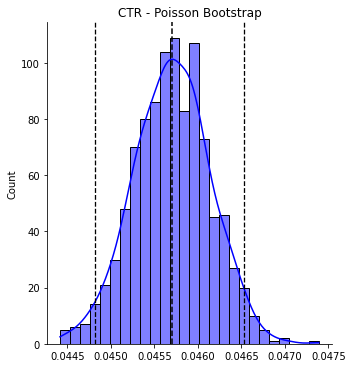

In [35]:
sns.displot(poisson_boot_res, kde=True, color='blue')
plt.title('CTR - Poisson Bootstrap')
plt.axvline(poisson_boot_res.mean(), ls='--', lw=1.5, c='black')
plt.axvline(quantile_l, ls='--', lw=1.3, c='black')
plt.axvline(quantile_r, ls='--', lw=1.3, c='black')
plt.show()